# 5. Example: 4DVar Backprop DA using Reservoir Computing ML Model on QGS Model

Using RP model from QGS/Jason Platt's paper: 

In [1]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.sparse.linalg import bicgstab
from scipy.linalg import inv
from scipy.sparse.linalg import aslinearoperator
from copy import deepcopy
import jax.numpy as jnp
from jax import value_and_grad
from IPython.lib.deepreload import reload
import pickle
from qgs.params.params import QgParams
from timeit import default_timer as timer
import pandas as pd


from ray import train, tune
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch


In [2]:
random_seed=50
np_rng = np.random.default_rng(seed=random_seed)

## A. Create Nature Run

In [3]:
# Time parameters
dt = 0.5
# transient time to attractor
transient_time = 1.e5
# integration time on the attractor
integration_time = 1.e4


# Setting some model parameters
# Model parameters instantiation with some non-default specs
model_params = QgParams({'phi0_npi': np.deg2rad(50.)/np.pi, 'hd': 0.1})
# Mode truncation at the wavenumber 2 in both x and y spatial coordinate
model_params.set_atmospheric_channel_fourier_modes(2, 2)

# Changing (increasing) the orography depth and the meridional temperature gradient
model_params.ground_params.set_orography(0.2, 1)
model_params.atemperature_params.set_thetas(0.2, 0)

In [4]:
train_size = 100000
transient_size = 1000
valid_size = 10000
test_size = 10000

In [5]:
nature_run = dab.data.QGS(model_params=model_params, store_as_jax=False, delta_t=dt,
                          random_seed=random_seed)
nature_run.generate(n_steps=200*1000, stride=1000, x0=np_rng.random(model_params.ndim)*0.001, mxstep=5000)
x0 = nature_run.values[-1]

In [6]:
nature_run.generate(x0=x0, n_steps=(train_size +  valid_size + transient_size + test_size), mxstep=5000)

In [7]:
# nr_train, nr_transient, nr_valid_and_test = nature_run.split_train_valid_test(
#     train_size, transient_size, valid_size + test_size)
# nr_valid, nr_test, _ = nr_valid_and_test.split_train_valid_test(valid_size, test_size, 0)

In [8]:
nr_train, nr_valid, nr_transient_and_test = nature_run.split_train_valid_test(
    train_size, valid_size, transient_size + test_size)
nr_transient, nr_test, _ = nr_transient_and_test.split_train_valid_test(transient_size, test_size, 0)

/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +


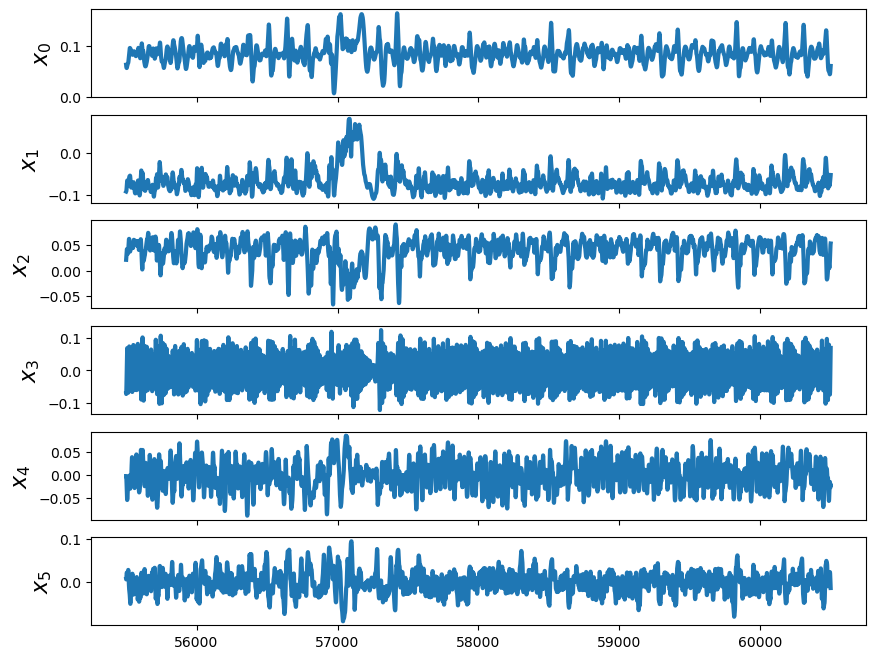

In [9]:
# Let's visualize the results
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nr_test.times, nr_test.values[:,j], lw = 3, label = 'Nature Run')
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
#     ax.set_xlim(54000, 55000)

## B. Generate Observations

In [10]:
# First we need to calculate the per-variable SD for QGS model
obs_sd_scale = 0.1
per_variable_sd = np.std(nr_train.values, axis=0)
obs_sd = 0.1*per_variable_sd

In [11]:
# Now we can define the observer:
obs_qgs_test = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, nr_test.time_dim, 3), # Observation every 5th timestep
    random_location_count = 10,
    error_bias = 0.0, 
    error_sd = obs_sd, 
    random_seed=93,
    stationary_observers=True,
    store_as_jax=False
)

# Now we can define the observer:
obs_qgs_valid = dab.observer.Observer(
    nr_valid, # Data generator object
    time_indices = np.arange(0, nr_valid.time_dim, 3), # Observation every 5th timestep
    random_location_count = 10,
    error_bias = 0.0, 
    error_sd = obs_sd,  
    random_seed=93,
    stationary_observers=True,
    store_as_jax=False
)

# Making observations
obs_vec_valid = obs_qgs_valid.observe()
obs_vec_test = obs_qgs_test.observe()

## C. Define and train model

In [12]:
# Define model
forecast_model = dab.model.RCModel(
    system_dim=20, 
    reservoir_dim=2000, 
    input_dim=20, 
    sparse_adj_matrix=False, 
    sparsity=0.99,
    readout_method='linear',
    sigma=0.98765777241154,
    sigma_bias = 0.675882947305197,
    spectral_radius =  0.376752115791648, # SR 
    leak_rate=0.5343730100231164, # alpha
    log_beta=-20.219432227197363)

In [13]:
# # # Train: Takes a few minutes
# forecast_model.weights_init()
# forecast_model.train(nr_train)
# forecast_model.save_weights('rc_weights.pkl')

In [14]:
# Shortcut: load the W_out weights from previous training
weights_path = 'rc_weights.pkl'
forecast_model.weights_init()
forecast_model.load_weights(weights_path)

In [15]:
# What happens when we run our model without data assimilation?
valid_start = forecast_model.generate(nr_train.values[-1000:])[-1]

valid_run_hidden = [valid_start]
obs_index = 0
for i in range(valid_size-1):
    valid_run_hidden.append(
        forecast_model.update(valid_run_hidden[-1],
                              forecast_model.readout(valid_run_hidden[-1])
                              )
    )
valid_run_system = forecast_model.readout(valid_run_hidden)



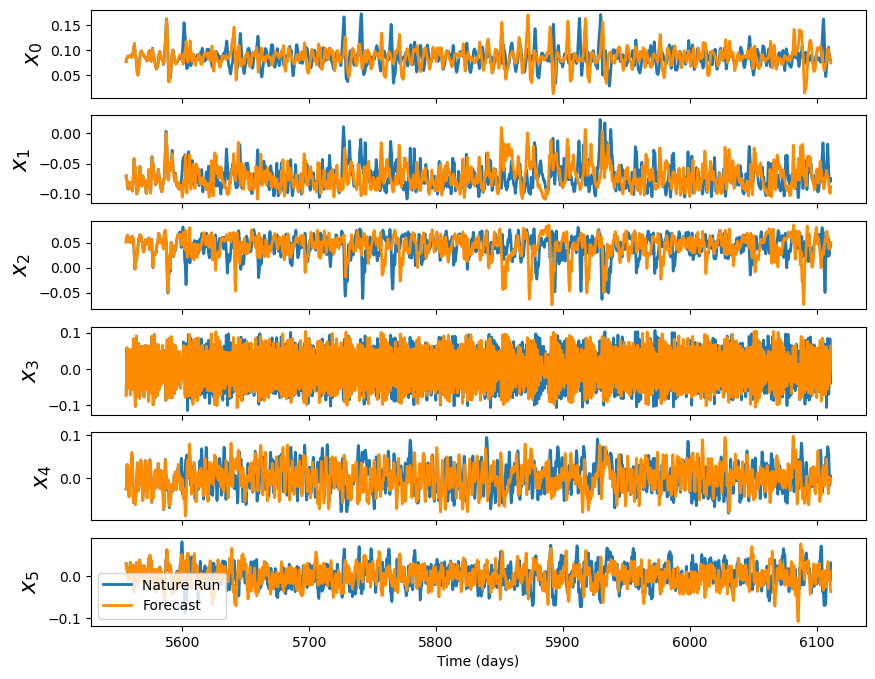

In [16]:
# Let's visualize the results
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nr_valid.times*160/(60*24), nr_valid.values[:,j], lw = 2, label = 'Nature Run')
    ax.plot(nr_valid.times*160/(60*24), valid_run_system[:,j], lw = 2, label = 'Forecast', color='darkorange')
#     ax.scatter(obs_vec_l96.times, obs_vec_l96.values[:,j],label='Obs', color='green', s=10)
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
ax.legend()
ax.set_xlabel('Time (days)')
plt.show()

## D. Set up and run DA Cycler for validation period

In [27]:
# Getting standard deviation of reservoir state values for sigma_bg
train_res_values = forecast_model.generate(nr_train.values)
train_res_sd = np.std(train_res_values, axis=0)

In [63]:
S.shape

(10, 20)

In [32]:
obs_total_size = 10*4
sigma_obs=np.tile(obs_sd[obs_vec_valid.location_indices[0]], 4)*1.25 # Used 0.005 normally, 0.01 increased error
sigma_bg = 0.1*train_res_sd #0.005 #0.05*obs_sd

R = (sigma_obs**2)*np.identity(obs_total_size)
B = (sigma_bg**2)*np.identity(forecast_model.reservoir_dim)
S = np.zeros((10, 20))
S[np.arange(S.shape[0]), np.tile(obs_vec_valid.location_indices[0], 1)] = 1
H = S @ forecast_model.Wout.T

In [33]:
r0_original = forecast_model.update(forecast_model.generate(
        nr_train.values[-1000:]
        + np.random.normal(size = (1000, nr_train.system_dim), scale=obs_sd))[-1], nr_train.values[-1])

In [34]:
def raytune_v4d_bp_valid(config, num_epochs, H, B, R, 
                         delta_t, forecast_model, r0_original,
                         nr, obs_vec, sigma_obs):
    
    dc = dab.dacycler.Var4DBackprop(
    system_dim=forecast_model.reservoir_dim,
    delta_t=delta_t,
    H=H,
    B=B,
    R=R,
    learning_rate=config['lr'],
    lr_decay=config['lr_decay'],
    num_epochs=num_epochs,
    model_obj=forecast_model,
    obs_window_indices=[0,2,5,8],
    steps_per_window=10, # 10 instead of 9 because inclusive
    loss_growth_limit=100
    )
    cur_tstep = 0

    r0_sv = dab.vector.StateVector(
        values=r0_original,
        store_as_jax=True)

    out_statevec = dc.cycle(
        input_state = r0_sv,
        start_time = nr.times[cur_tstep],
        obs_vector = obs_vec,
        analysis_window=4.5,
        timesteps=int(nr_valid.time_dim/9)-2,
        obs_error_sd=sigma_obs,
        analysis_time_in_window=2.25)
        
    rmse = np.sqrt(np.mean(np.square(nr.values[:-19] - forecast_model.readout(out_statevec.values))))
    
    train.report({'rmse':rmse})

### RayTune

In [35]:
space = {
    "lr": hp.loguniform("lr", -16, -12),
    "lr_decay": hp.uniform("lr_decay", 0.1, 0.9),
}
num_epochs = 3

In [36]:
trainable_w_num_epochs = tune.with_parameters(raytune_v4d_bp_valid, 
                                              delta_t=nature_run.delta_t,
                                              num_epochs=num_epochs,
                                              H=H,
                                              B=B,
                                              R=R,
                                              forecast_model=forecast_model,
                                              r0_original=r0_original,
                                              sigma_obs=sigma_obs,
                                              obs_vec=obs_vec_valid,
                                              nr=nr_valid
                                             )

trainable_nonparallel = tune.with_resources(trainable_w_num_epochs, {"cpu": 10})

In [37]:
hyperopt_search = HyperOptSearch(space, metric="rmse", mode="min")
tuner = tune.Tuner(
    trainable_nonparallel,
    tune_config=tune.TuneConfig(
        num_samples=50,
        search_alg=hyperopt_search,
    ),
)
results = tuner.fit()

cur_results_df = results.get_dataframe()

cur_results_df['num_epochs'] = num_epochs

(pid=14867) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=14867)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=14867) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=14867)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 14:41:25,698	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_05542024
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=15144) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=15144)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=15144) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=15144)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=15144) [[4.54887945e+01 5.97439266e+01 4.02257423e+01]
(raytune_v4d_bp_valid pid=15144)  [3.88490700e+01 1.21283925e+02 7.99254039e+01]
(raytune_v4d_bp_valid pid=15144)  [5.55501270e+01 5.97251543e+02 4.72317589e+02]
(raytune_v4d_bp_valid pid=15144)  ...
(raytune_v4d_bp_valid pid=15144)  [6.81639847e+05 1.79685528e+06 2.04064076e+06]
(raytune_v4d_bp_valid pid=15144)  [2.30159937e+05 5.90286820e+05 4.83650851e+05]
(raytune_v4d_bp_valid pid=15144)  [1.01382871e+06 3.61928548e+06 2.40848812e+06]]
(raytune_v4d_bp_valid pid=15144) [[4.54887945e+01 6.38591118e+01 1.07573155e+02]
(raytune_v4d_bp_valid pid=15144)  [9.86095626e+01 1.49946678e+03 6.71781633e+03]
(raytune_v4d_bp_valid pid=15144)  [1.16491378e+03 2.67361005e+04 7.35432764e+04]
(raytune_v4d_bp_valid pid=15144)  ...
(raytune_v4d_bp_valid pid=15144)  [1.02283164e+06 5.97277842e+06 3.45924765e+06]
(raytune_v4d_bp_valid pid=15144)  [2.33412773e+06 7.90449976e+06 3.41713381e+06]
(raytune_v4d_bp_valid pid=15144)

2024-01-17 14:52:14,353	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_f1ee5eaa
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=15144, ip=192.168.0.249, actor_id=2cbc93b65fe19697f6c9a22f01000000, repr=raytune_

(pid=15919) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=15919)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=15919) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=15919)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=15919) [[45.48879446 36.70358042 36.17640453]
(raytune_v4d_bp_valid pid=15919)  [40.39911887 31.25621118 30.98977046]
(raytune_v4d_bp_valid pid=15919)  [34.79297479 29.32669866 29.04454567]
(raytune_v4d_bp_valid pid=15919)  ...
(raytune_v4d_bp_valid pid=15919)  [38.41844337 34.21609491 33.8390622 ]
(raytune_v4d_bp_valid pid=15919)  [41.68530853 33.8673031  33.54368693]
(raytune_v4d_bp_valid pid=15919)  [35.78762592 31.50578642 31.3300636 ]]
(raytune_v4d_bp_valid pid=15919) [[45.48879446 38.37931588 35.81070483]
(raytune_v4d_bp_valid pid=15919)  [40.22440309 32.12326996 30.7008844 ]
(raytune_v4d_bp_valid pid=15919)  [35.27944133 30.01716345 28.67029003]
(raytune_v4d_bp_valid pid=15919)  ...
(raytune_v4d_bp_valid pid=15919)  [37.46133501 33.69191319 31.89867729]
(raytune_v4d_bp_valid pid=15919)  [39.40640595 33.12484012 31.71665956]
(raytune_v4d_bp_valid pid=15919)  [42.91658854 35.00287327 33.6117198 ]]
(raytune_v4d_bp_valid pid=15919) [[45.48879446 32.26596552

2024-01-17 15:04:29,471	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_d537e5de
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=15919, ip=192.168.0.249, actor_id=3c488da6c8885a23249026ff01000000, repr=raytune_

(pid=16828) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=16828)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=16828) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=16828)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:04:51,350	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_56dd2f16
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=17028) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=17028)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=17028) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=17028)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=17028)  [35.46016884 32.2876491  31.66744922]] [repeated 6x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(raytune_v4d_bp_valid pid=17028)  ...


2024-01-17 15:07:34,196	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_442114e7
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=17028, ip=192.168.0.249, actor_id=20b8cd73293e11e3cae502c001000000, repr=raytune_

(pid=17384) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=17384)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=17384) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=17384)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:07:56,686	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_06ca13ea
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=17627) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=17627)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=17627) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=17627)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:08:18,416	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_b86d634c
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=17828) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=17828)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=17828) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=17828)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:08:39,716	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_4ef71d15
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=18027) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=18027)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=18027) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=18027)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=18027)  ...
(raytune_v4d_bp_valid pid=18027)  [47.68741062 35.66571455 33.57677893]] [repeated 6x across cluster]


2024-01-17 15:11:20,153	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_582d71ad
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=18027, ip=192.168.0.249, actor_id=1405ea5929d428d78e72730201000000, repr=raytune_

(pid=18377) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=18377)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=18377) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=18377)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:11:43,323	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_331d2846
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=18586) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=18586)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=18586) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=18586)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:12:06,966	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_fcfe6090
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=18810) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=18810)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=18810) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=18810)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:12:28,019	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_d275dea9
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=19010) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=19010)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=19010) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=19010)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:12:49,331	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_39cacbd3
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=19251) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=19251)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=19251) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=19251)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:13:11,250	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_34d627e1
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=19598) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=19598)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=19598) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=19598)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=19598) [[  45.48879446   46.81142839   32.89633771]
(raytune_v4d_bp_valid pid=19598)  [  41.45471967  116.14002639   47.6653095 ]
(raytune_v4d_bp_valid pid=19598)  [  50.74981763  312.46921442  116.5026494 ]
(raytune_v4d_bp_valid pid=19598)  [ 253.13447916 1460.0195111   477.65624842]
(raytune_v4d_bp_valid pid=19598)  [ 116.02794974  877.09807973  405.3176378 ]
(raytune_v4d_bp_valid pid=19598)  [ 148.68420599  578.97955093  255.9927924 ]]
(raytune_v4d_bp_valid pid=19598)  ...
(raytune_v4d_bp_valid pid=19598) [[45.48879446 36.71410101 34.86776958]
(raytune_v4d_bp_valid pid=19598)  [40.5526831  31.10388392 30.19858613]
(raytune_v4d_bp_valid pid=19598)  [35.04074283 29.11485851 28.13185166]
(raytune_v4d_bp_valid pid=19598)  ...
(raytune_v4d_bp_valid pid=19598)  [37.15161952 32.4538675  31.03178772]
(raytune_v4d_bp_valid pid=19598)  [39.27978562 32.0825433  31.15613527]
(raytune_v4d_bp_valid pid=19598)  [43.29164144 34.26230187 33.19916053]]


2024-01-17 15:19:25,902	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_5d22113a
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=19598, ip=192.168.0.249, actor_id=23d6a02bb18df6f41d85e77801000000, repr=raytune_

(pid=20339) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=20339)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=20339) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=20339)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:19:48,344	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_cb6bb769
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=20536) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=20536)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=20536) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=20536)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=20536)  [5.45980892e+05 1.73190166e+06 1.76883792e+06]] [repeated 6x across cluster]
(raytune_v4d_bp_valid pid=20536)  ...


2024-01-17 15:22:33,728	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_969dc02b
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=20536, ip=192.168.0.249, actor_id=af697ad2910253ee9a84c3da01000000, repr=raytune_

(pid=21192) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=21192)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=21192) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=21192)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=21192)  ...
(raytune_v4d_bp_valid pid=21192)  [1.99469812e+06 4.61499254e+06 2.95673691e+06]] [repeated 6x across cluster]
(raytune_v4d_bp_valid pid=21192)  ...
(raytune_v4d_bp_valid pid=21192)  [48.79202783 44.78057935 34.72789351]] [repeated 6x across cluster]


2024-01-17 15:28:06,622	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_b4baa0c8
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=21192, ip=192.168.0.249, actor_id=7023d7e122e9c6e4fd547d6701000000, repr=raytune_

(pid=21828) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=21828)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=21828) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=21828)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=21828) [[  45.48879446   34.26178929   31.6415056 ]
(raytune_v4d_bp_valid pid=21828)  [  51.63772884  105.13924846   55.39672894]
(raytune_v4d_bp_valid pid=21828)  [  39.86400234   35.19634765   28.41868301]
(raytune_v4d_bp_valid pid=21828)  ...
(raytune_v4d_bp_valid pid=21828)  [ 905.17154761 4775.76282555 1646.35493795]
(raytune_v4d_bp_valid pid=21828)  [ 906.33957454 4685.4620139  1510.68735733]
(raytune_v4d_bp_valid pid=21828)  [1293.84948072 7021.01735572 2249.37603992]]


2024-01-17 15:30:59,667	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_dae1a15b
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=21828, ip=192.168.0.249, actor_id=e902885780c9b2e51d880eb101000000, repr=raytune_

(pid=22241) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=22241)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=22241) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=22241)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:31:23,212	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_8f861e4d
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=22454) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=22454)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=22454) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=22454)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=22454) [[45.48879446 32.8760758  30.07951438]
(raytune_v4d_bp_valid pid=22454)  [42.1871175  55.19922913 30.22868605]
(raytune_v4d_bp_valid pid=22454)  [40.3866891  56.11403831 28.935426  ]
(raytune_v4d_bp_valid pid=22454)  [43.32624035 27.25183701 25.09211692]
(raytune_v4d_bp_valid pid=22454)  [42.85362931 40.20629747 31.65332104]
(raytune_v4d_bp_valid pid=22454)  [49.66299011 71.7139012  38.74721895]]
(raytune_v4d_bp_valid pid=22454)  ...


2024-01-17 15:34:33,669	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_71ba21f1
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=22454, ip=192.168.0.249, actor_id=ed71710c01504ad9dddb823401000000, repr=raytune_

(pid=22986) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=22986)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=22986) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=22986)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:34:57,191	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_8fd58748
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=23187) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=23187)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=23187) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=23187)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=23187)  ...
(raytune_v4d_bp_valid pid=23187)  [48.30543103 49.63682991 38.21450215]] [repeated 5x across cluster]
(raytune_v4d_bp_valid pid=23187)  [44.55997501 39.54087343 33.4733643 ]


2024-01-17 15:37:53,807	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_ce2239b8
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=23187, ip=192.168.0.249, actor_id=b5ef6daa825663ab93fac27c01000000, repr=raytune_

(pid=23601) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=23601)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=23601) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=23601)   warnings.warn("Parameter configured to perform dimensional conversion " +


(raytune_v4d_bp_valid pid=23601)  ...
(raytune_v4d_bp_valid pid=23601)  [48.2291791  38.36886162 33.45723854]] [repeated 6x across cluster]


2024-01-17 15:40:51,255	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_0e4f69f0
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/_private/worker.py", line 2563, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(XlaRuntimeError): ray::ImplicitFunc.train() (pid=23601, ip=192.168.0.249, actor_id=e3be497e15f9335b65d2971201000000, repr=raytune_

(pid=23999) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=23999)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=23999) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=23999)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:41:16,621	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_17690400
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=24221) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=24221)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=24221) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=24221)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:41:41,252	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_33a59208
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=24463) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=24463)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=24463) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=24463)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:42:05,970	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_ad391e1f
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=24663) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=24663)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=24663) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=24663)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:42:29,860	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_e3b73dee
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=24889) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=24889)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=24889) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=24889)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:42:54,707	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_c5a9c387
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

(pid=25110) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(pid=25110)   warnings.warn("Parameter configured to perform dimensional conversion " +
(raytune_v4d_bp_valid pid=25110) /home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
(raytune_v4d_bp_valid pid=25110)   warnings.warn("Parameter configured to perform dimensional conversion " +
2024-01-17 15:43:20,456	ERROR tune_controller.py:1383 -- Trial task failed for trial raytune_v4d_bp_valid_19fdc3e1
Traceback (most recent call last):
  File "/home/ksolvik/miniconda3/envs/dab-installed/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110

2024-01-17 15:43:20,498	ERROR tune.py:1043 -- Trials did not complete: [raytune_v4d_bp_valid_05542024, raytune_v4d_bp_valid_f1ee5eaa, raytune_v4d_bp_valid_d537e5de, raytune_v4d_bp_valid_56dd2f16, raytune_v4d_bp_valid_442114e7, raytune_v4d_bp_valid_06ca13ea, raytune_v4d_bp_valid_b86d634c, raytune_v4d_bp_valid_4ef71d15, raytune_v4d_bp_valid_582d71ad, raytune_v4d_bp_valid_331d2846, raytune_v4d_bp_valid_fcfe6090, raytune_v4d_bp_valid_d275dea9, raytune_v4d_bp_valid_39cacbd3, raytune_v4d_bp_valid_34d627e1, raytune_v4d_bp_valid_5d22113a, raytune_v4d_bp_valid_cb6bb769, raytune_v4d_bp_valid_969dc02b, raytune_v4d_bp_valid_b4baa0c8, raytune_v4d_bp_valid_dae1a15b, raytune_v4d_bp_valid_8f861e4d, raytune_v4d_bp_valid_71ba21f1, raytune_v4d_bp_valid_8fd58748, raytune_v4d_bp_valid_ce2239b8, raytune_v4d_bp_valid_0e4f69f0, raytune_v4d_bp_valid_17690400, raytune_v4d_bp_valid_33a59208, raytune_v4d_bp_valid_ad391e1f, raytune_v4d_bp_valid_e3b73dee, raytune_v4d_bp_valid_c5a9c387, raytune_v4d_bp_valid_19fdc3e1

In [49]:
cur_results_df.to_csv('./test_raytune_qgs_v3.csv')